Inicialización del programa

In [1]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import triangle
import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,8  # Default image size for this interactive session

In [2]:
#Properties of Planet Candidate (Data taken from Spreadsheet)
depth = 0.15*0.01 # (In absolute terms)
period = 19.306566 # (In days)
ecc = 0.0
b = 0.5

t0 = 1919.57971 # (-2454900) 
Rp = 3.47 
Mp = 31.87

#Star properties (from http://arxiv.org/pdf/1503.07866v1.pdf)
mass = 0.93
masserr = (0.05+0.06)/2.0
radius = 0.93
radiuserr = (0.05+0.06)/2.0
Teff = 5553

# From Claret (From Roberto's USPmass program)
u1 = 0.44 
u2 = 0.24
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

Lectura del archivo

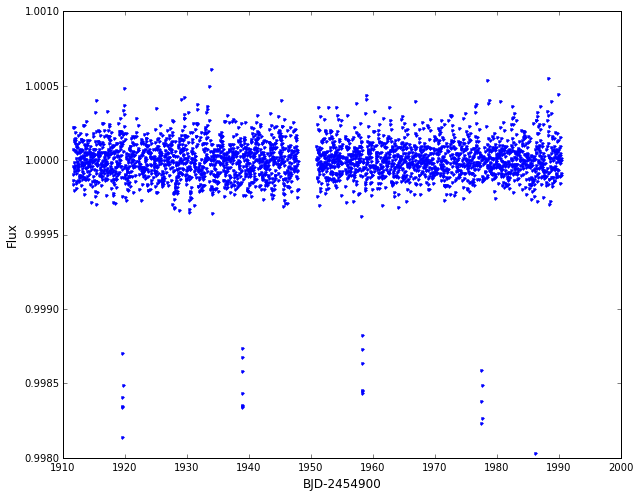

In [3]:
import glob, os
os.chdir("/Users/mariona/Desktop/summer2015")
for file in glob.glob("LCfluxesepic*.txt"):
    data = pd.read_table(file, sep='\s+', header = None, names=['time', 'flux','other'])
    timeLC = data['time']
    fluxLC = data['flux']
    errorLC = np.std(fluxLC)
    meanFlux = np.mean(fluxLC)
    goodP = fluxLC<=meanFlux+3*errorLC
    plt.figure(1)
    plt.plot(timeLC[goodP], fluxLC[goodP],'.')
    plt.xlabel('BJD-2454900', fontsize=12)
    plt.ylabel('Flux', fontsize=12)

In [4]:
minTime = min(timeLC) 
maxTime = max(timeLC)

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step
        
minepoch = -10
maxepoch = 20
numepochs = maxepoch-minepoch+1

transitLoc = np.empty(numepochs)

for x in my_range(minepoch, maxepoch, 1):
    transit = t0+x*period
    transitLoc[x-minepoch]=transit
    
goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
transits = transitLoc[goodTrans] # Stores transit times

[ 1919.57971   1938.886276  1958.192842  1977.499408]


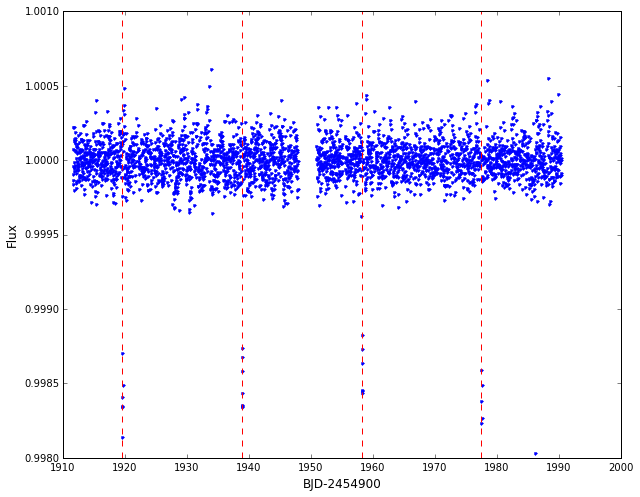

In [5]:
print transits
num_transits = len(transits)
plt.figure(2)
plt.plot(timeLC[goodP], fluxLC[goodP],'.')
plt.xlabel('BJD-2454900', fontsize=12)
plt.ylabel('Flux', fontsize=12)
for i in range(0,num_transits):
    plt.axvline(transits[i],color='r',ls='dashed')

106


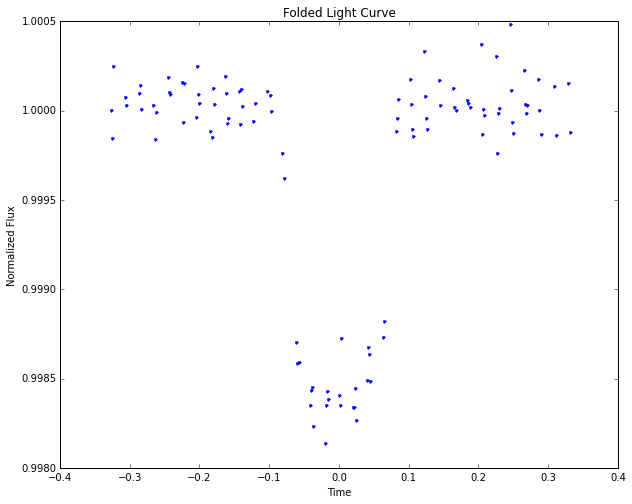

In [6]:
# Selección de puntos que están a menos de X horas del tránsito

t=timeLC[goodP]
f=fluxLC[goodP]
transit_window = 8.0 #In hours
window = transit_window/24 # In days

sumPoints=0

for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   sumPoints=np.sum(selPoints)+sumPoints

print sumPoints #Cantidad total de puntos en los 4 tránsitos en la franja que nos interesa

timeTrans = np.empty(sumPoints)
fluxTrans = np.empty(sumPoints)
flag = np.empty(sumPoints)
midTrans = np.empty(sumPoints)

sumPoints = 0
for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   numPoints = np.sum(selPoints)
   timeTrans[0+sumPoints:numPoints+sumPoints] = t[selPoints]
   fluxTrans[0+sumPoints:numPoints+sumPoints] = f[selPoints]
   flag[0+sumPoints:numPoints+sumPoints] = i
   midTrans[0+sumPoints:numPoints+sumPoints] = transits[i] 
   sumPoints = numPoints + sumPoints 

#Plot the folded light curve:
dt = timeTrans-midTrans
plt.plot(dt, fluxTrans,'.')
plt.title('Folded Light Curve')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')

In [7]:
rangeTransit = 0.1

dataBool = np.abs(dt)>=rangeTransit #True: Point is outside of the transit.
print dataBool
out = (timeTrans<=rangeTransit) & (timeTrans>=rangeTransit) # Returns boolean"

[ True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True False False False False False False  True
  True  True  True  True  True  True  True  True  True  True]


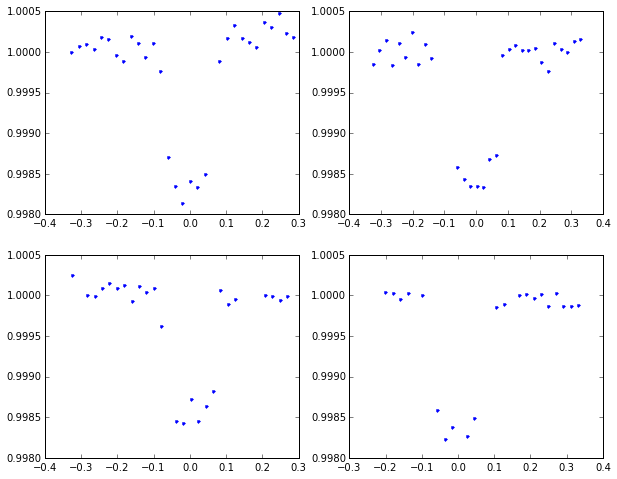

In [8]:
#Plot each transit
plt.figure(3)
for i in range(0,len(transits)):
    transitBool=(flag==i) # np.abs(dt)>=rangeTransit
    plt.subplot(2,2,i+1)
    plt.plot(dt[transitBool],fluxTrans[transitBool],'.')

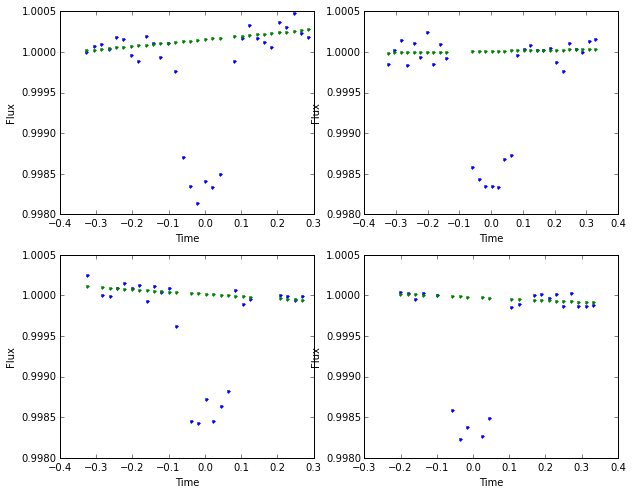

In [9]:
#Fit to the regions outside of the transit
plt.figure(4)
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    plt.subplot(2,2,i+1)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    plt.plot(dt[transitBool],p(dt[transitBool]),'.')
    plt.xlabel('Time')
    plt.ylabel('Flux')

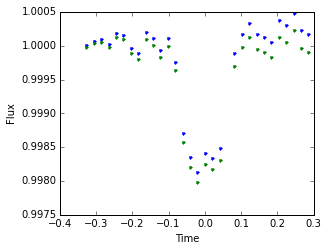

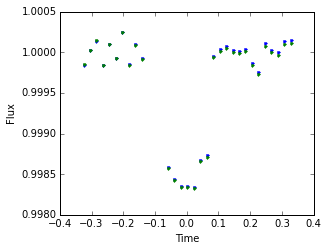

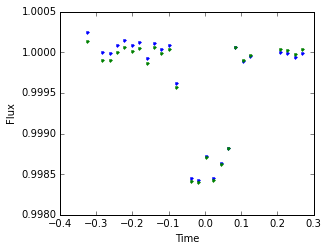

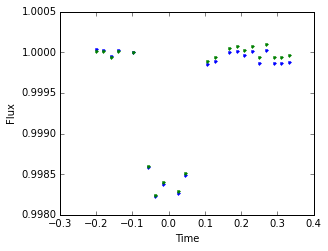

In [10]:
#Divide the light curves by the fit 
plt.figure(5)
corFlux=fluxTrans
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    plt.subplot(2,2,i+1)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    plt.plot(dt[transitBool],fluxTrans[transitBool]/p(dt[transitBool]),'.')
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.show()
    corFlux[transitBool]=fluxTrans[transitBool]/p(dt[transitBool])

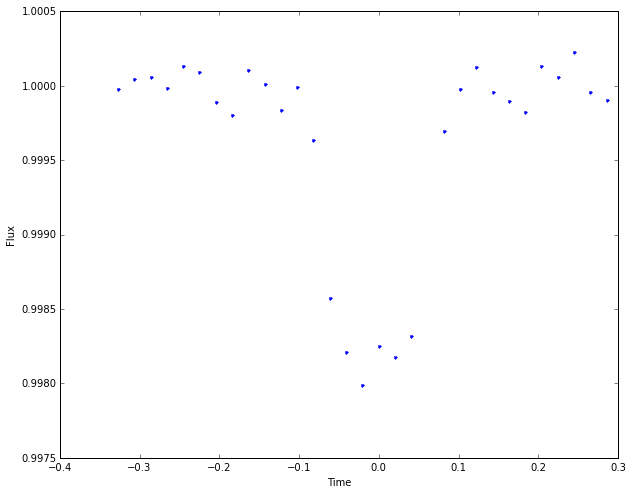

In [12]:
#First transit
corFlux=fluxTrans
transitBool=(flag==0)
outsideBool=(np.abs(dt)>=rangeTransit) & (flag==0)
z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
p=np.poly1d(z)
corFlux[transitBool]=fluxTrans[transitBool]/p(dt[transitBool])

dt_1=dt[transitBool]
corFlux_1=corFlux[transitBool]

plt.figure(6)
plt.plot(dt_1,corFlux_1,'.')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [16]:
#From best guesses (check LCAnalysis_1)
depth_ml = 0.0015669276217474255
b_ml = 0.62688198679744078
sigma_ml = 4.0382821939991208e-11
sumLD_ml = 0.62054242543638494
mass_ml = 0.92718951248481241 #Best estimate for mass of the star
radius_ml = 0.94091569399602548 #Best estimate for radius of the star
f0_ml = 1.0000012139894519

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep, depth_ml, b_ml, sigma_ml, 
            sumLD_ml, mass_ml, radius_ml, f0_ml]

[19.306566, 0.0, 0.93, 0.055, 0.93, 0.055, 0.2, 0.020430555555555556, 0.0015669276217474255, 0.6268819867974408, 4.038282193999121e-11, 0.6205424254363849, 0.9271895124848124, 0.9409156939960255, 1.0000012139894519]


In [22]:
import transit
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):

    #Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    #theta[0] = single_pt0 = time of transit
 
    pt0_single = theta
    period, ecc,mass, masserr, radius, radiuserr, diffLD, tKep, depth_ml, b_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml = allfixed 
    
    u1 = 0.5*(sumLD_ml+diffLD) 
    u2 = sumLD_ml-u1
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass=mass_ml,radius=radius_ml))
    body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=pt0_single, b=np.abs(b_ml), e=ecc)
    s.add_body(body)
    
    inv_sigma2 = 1.0/(errorLC**2 + sigma_ml**2)
    
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)  
    ftheo = ftheo-1+f0_ml
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((mass_ml-mass)/masserr)**2
            + ((radius_ml-radius)/radiuserr)**2)

In [27]:
nll_2 = lambda *args: -lnlike(*args)
result = op.minimize(nll_2, [0.0],args=(dt_1, corFlux_1, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')
fit_pt0_single = result["x"]

Optimization terminated successfully.
         Current function value: -245.957096
         Iterations: 8
         Function evaluations: 16


Compute the LC integrated over a Kepler long cadence exposure time with the results obtained in minimization process.

In [25]:
s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = mass_ml, radius = radius_ml))
body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=fit_pt0_single, b=np.abs(b_ml), e=ecc)
s.add_body(body)

t_theory = np.arange(-1, 1, tKep*0.01)
f_theory = s.light_curve(t_theory, texp=tKep, tol=1e-08, maxdepth=4)
f_theory = f_theory-1.0 + f0_ml

Plot of the theoretical and the observed data on the same graph

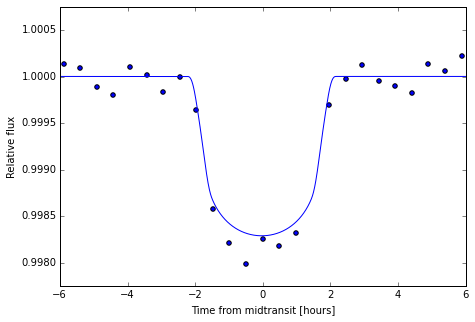

In [26]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*dt_1,corFlux_1)
plt.xlim([-6.0, 6.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24.0*t_theory, f_theory)

Print the best guess for the transit time. 

In [29]:
print fit_pt0_single

[-0.001375]


With the best fit solution, we'll run an MCMC routine to estimate the uncertainties on the parameters

In [51]:
ndim, nwalkers = 1, 100 # 1 dimension because we're only fitting 1 parameter.
pos = [result["x"]*(1+1e-4*np.random.randn(ndim)) for i in range(nwalkers)]

In [52]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(dt_1, corFlux_1, errorLC, allfixed))
st = 1000
sampler.run_mcmc(pos, st)

(array([[ -9.23214089e-04],
        [ -5.20014585e-03],
        [ -6.50567893e-03],
        [ -4.05626342e-03],
        [ -7.37967157e-03],
        [ -6.70343234e-03],
        [ -1.45021811e-03],
        [  3.44144722e-03],
        [ -1.44747594e-04],
        [  5.25859045e-04],
        [ -6.78635588e-03],
        [ -5.94194701e-03],
        [ -3.93184786e-03],
        [ -5.13614302e-03],
        [ -1.31705768e-03],
        [  1.22780889e-03],
        [  1.25989024e-03],
        [ -9.38122048e-05],
        [ -2.82852715e-03],
        [  5.61140152e-03],
        [  2.84211202e-03],
        [ -6.26761846e-03],
        [ -6.18082166e-04],
        [ -9.27899561e-03],
        [  2.06321184e-03],
        [ -2.44599196e-03],
        [ -6.82093353e-03],
        [ -5.55265891e-04],
        [  8.63759157e-04],
        [  2.39450260e-03],
        [ -4.15667772e-04],
        [ -3.37183175e-03],
        [ -4.40038566e-03],
        [ -5.85215341e-04],
        [ -5.48370953e-03],
        [ -3.1367950

In [40]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

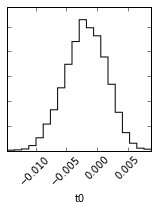

In [41]:
import triangle
fig = triangle.corner(samples, labels=["t0"])
#fig.savefig("triangle.png")